# Stock Prediction RNN

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict CVS Health's stock price 14 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

# Pytorch LSTM Stock Predictor

This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/), and also available elsewhere in this repo as a notebook.

## Step 1: Loading the data

First let's load in our time series - a history of around 50 years of CVS's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [98]:
# download the data, please copy the data source into the sample_data folder!
import os
# os.getcwd()
os.chdir('/content/sample_data')

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [100]:
# Importing the training set
dataset = data = pd.read_csv('CVS (1).csv')
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1973-02-21,1.625000,1.625000,1.625000,1.625000,0.668224,420800
1,1973-02-22,1.656250,1.656250,1.656250,1.656250,0.681075,92800
2,1973-02-23,1.703125,1.703125,1.703125,1.703125,0.700350,400000
3,1973-02-26,1.671875,1.671875,1.671875,1.671875,0.687500,187200
4,1973-02-27,1.546875,1.546875,1.546875,1.546875,0.636098,657600


In [76]:
dataset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
12726,2023-08-08,73.190002,74.190002,72.650002,74.000000,74.000000,6612000
12727,2023-08-09,73.919998,75.309998,73.830002,74.599998,74.599998,6914700
12728,2023-08-10,74.830002,75.349998,73.680000,73.959999,73.959999,6057700
12729,2023-08-11,73.760002,75.000000,73.690002,74.870003,74.870003,5977600
12730,2023-08-14,74.699997,74.769997,74.000000,74.339996,74.339996,7155500


In [101]:
# we are predicting the close values
dataset_cl = dataset['Close'].values

# dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
# training_set = dataset_train.iloc[:, 1:2].values

In [102]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

In [103]:
dataset_cl.shape

(12731, 1)

This dataset is from 1973-02 to 2023-08

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [131]:
#Create a function to process the data into 14 day look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(dataset_cl, 14)


## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [132]:
X_train, X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train, y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

11444
1272
11444
1272


In [ ]:
# Reshaping
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [133]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)

        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [ ]:
# stacking two of them
# ref: https://discuss.pytorch.org/t/stacked-two-lstms-with-different-hidden-layers/62554
'''
class RNN(nn.Module):
    def __init__(self, i_size_1, h_size_1, n_layers_1, dropout_1, \
                 i_size_2, h_size_2, n_layers_2, dropout_2, bidirectional_1=True,\
                 bidirectional_2=True):

        super(RNN, self).__init__()
        self.num_directions = bidirectional_1+1
        self.h_size_1 = h_size_1
        self.h_size_2 = h_size_2
        self.n_layers_1 =n_layers_1
        self.n_layers_2 = n_layers_2
        # we can globalize the parameter just as above, for better assigning vars while stacking

        # 1st layer
        self.rnn_1 = nn.LSTM(
            input_size=i_size_1,
            hidden_size=h_size_1,
            num_layers=n_layers_1,
            dropout=dropout_1,
            bidirectional=bidirectional_1
        )

        # 2nd stacked layer
        self.rnn_2 = nn.LSTM(
            input_size=i_size_2,
            hidden_size=h_size_2,
            num_layers=n_layers_2,
            dropout=dropout_2,
            bidirectional=bidirectional_2
        )
        self.lin = nn.Linear(self.h_size_2, 1) # output size = 1 in this case, so I deleted such a function parameter



    def forward(self, input):
        h_t1 = Variable(torch.zeros(self.n_layers_1, input.size()[1], self.h_size_1))
        c_t1 = Variable(torch.zeros(self.n_layers_1, input.size()[1], self.h_size_1))
        h_t2 = Variable(torch.zeros(self.n_layers_2, input.size()[1], self.h_size_2))
        c_t2 = Variable(torch.zeros(self.n_layers_2, input.size()[1], self.h_size_2))
        outputs = []

        for i, input_t in enumerate(input.chunk(input.size(1))):
            _, (h_t1, c_t1) = self.rnn_1(input_t, (h_t1, c_t1))
            _, (h_t2, _) = self.rnn_2(h_t1, (h_t2, c_t2))
            output = self.out(h_t2[-1])
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)

        return outputs

'''

In [146]:
# Globals

INPUT_SIZE = 14
HIDDEN_SIZE = 256
NUM_LAYERS = 4
OUTPUT_SIZE = 1
BATCH_SIZE = 256
# Hyper parameters

learning_rate = 0.0003
num_epochs = 450

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [147]:
rnn

RNN(
  (rnn): LSTM(14, 256, num_layers=4, dropout=0.1)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
"""
class StockDataset(Dataset):

    def __init__(self, X_dataset, Y_dataset):

        self.X_dataset = torch.from_numpy(X_dataset)
        self.Y_dataset = torch.from_numpy(Y_dataset)

    def __len__(self):
        return np.shape(self.Y_dataset)[0]

    def __getitem__(self, idx):

        sample = {'Sequence': self.X_dataset[:,idx,:], "Target": self.Y_dataset[idx]}


        return sample
"""

'\nclass StockDataset(Dataset):\n\n    def __init__(self, X_dataset, Y_dataset):\n\n        self.X_dataset = torch.from_numpy(X_dataset)\n        self.Y_dataset = torch.from_numpy(Y_dataset)\n\n    def __len__(self):\n        return np.shape(self.Y_dataset)[0]\n\n    def __getitem__(self, idx):\n\n        sample = {\'Sequence\': self.X_dataset[:,idx,:], "Target": self.Y_dataset[idx]}\n\n\n        return sample\n'

In [ ]:
# Train_ds=StockDataset(X_train, y_train)

In [148]:
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state)
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters

    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.08602745831012726, eval loss 0.433650940656662
epoch 1, loss 0.07666704803705215
epoch 2, loss 0.06833412498235703
epoch 3, loss 0.06087106838822365
epoch 4, loss 0.05423340946435928
epoch 5, loss 0.04869755357503891
epoch 6, loss 0.044829435646533966
epoch 7, loss 0.04352272301912308
epoch 8, loss 0.04473874345421791
epoch 9, loss 0.0450216569006443
epoch 10, loss 0.042115937918424606
epoch 11, loss 0.037019889801740646
epoch 12, loss 0.03148321807384491
epoch 13, loss 0.02572580799460411
epoch 14, loss 0.019767479971051216
epoch 15, loss 0.013137425296008587
epoch 16, loss 0.009257007390260696
epoch 17, loss 0.008832602761685848
epoch 18, loss 0.004857618827372789
epoch 19, loss 0.004193666856735945
epoch 20, loss 0.005264318082481623, eval loss 0.010808569379150867
epoch 21, loss 0.004607325419783592
epoch 22, loss 0.0033043529838323593
epoch 23, loss 0.003460588399320841
epoch 24, loss 0.003910184372216463
epoch 25, loss 0.0029114335775375366
epoch 26, loss 0.002084

In [149]:

def no_of_argu(*args):

    # using len() method in args to count
    return(len(args))
print(no_of_argu(inputs_cuda, hidden_state))

2


In [150]:
rnn.out.weight # see parameter of the model

Parameter containing:
tensor([[ 1.5921e-02, -2.5611e-02, -1.6693e-02,  1.3640e-02,  3.1032e-02,
         -5.2221e-02,  2.4432e-02, -1.8014e-02, -6.0699e-02, -1.6074e-02,
         -6.8805e-03, -2.4205e-02, -1.9831e-02, -3.5386e-03, -3.3309e-03,
          9.0366e-03,  1.9467e-02,  1.6396e-03,  5.9157e-02, -4.5574e-03,
         -1.0405e-02,  2.6195e-02, -3.2736e-02,  1.7771e-02, -4.8363e-02,
         -4.9429e-02, -4.0528e-02,  4.0495e-03,  4.2554e-02,  2.2213e-02,
         -5.6449e-02,  1.9793e-02, -4.9013e-02,  3.9525e-02,  1.3044e-02,
          3.8509e-02, -2.9603e-03,  1.0179e-02,  2.3468e-02,  1.4209e-02,
         -3.8368e-02,  2.0516e-02,  1.2382e-02, -5.5042e-02,  1.9720e-02,
          6.1230e-02, -2.3756e-02,  2.5662e-02,  4.9939e-02, -2.5965e-02,
          2.6552e-02, -3.9461e-03,  4.3415e-02, -5.7797e-03, -5.0029e-02,
          1.1254e-02, -1.9603e-02,  1.5153e-02,  5.0136e-02, -1.3191e-02,
         -2.1597e-02, -3.3162e-02, -4.1044e-04, -5.9338e-02, -6.6550e-03,
         -5.3245

In [151]:
for param in rnn.parameters():
    print(param.data)

tensor([[-0.0414, -0.0294,  0.0179,  ...,  0.0147,  0.0037, -0.0560],
        [-0.0455, -0.0115, -0.0395,  ..., -0.0283,  0.0379,  0.0199],
        [-0.0127,  0.0450, -0.0592,  ...,  0.0216, -0.0505,  0.0486],
        ...,
        [ 0.0104, -0.0325, -0.0476,  ..., -0.0355,  0.0476,  0.0008],
        [-0.0331,  0.0350, -0.0485,  ..., -0.0294,  0.0075, -0.0001],
        [ 0.0623,  0.0055, -0.0319,  ...,  0.0485, -0.0560,  0.0139]],
       device='cuda:0')
tensor([[ 0.0124, -0.0344, -0.0111,  ..., -0.0099, -0.0446,  0.0118],
        [ 0.0289, -0.0081, -0.0719,  ...,  0.0255,  0.0664, -0.0676],
        [-0.0438, -0.0383,  0.0154,  ..., -0.0608,  0.0069,  0.0011],
        ...,
        [-0.0550,  0.0299, -0.0403,  ..., -0.0524, -0.0579, -0.0079],
        [-0.0344, -0.0076,  0.0539,  ...,  0.0517, -0.0351, -0.0564],
        [ 0.0142, -0.0128, -0.0012,  ...,  0.0331, -0.0421, -0.0071]],
       device='cuda:0')
tensor([ 0.0302, -0.0554,  0.0589,  ..., -0.0437,  0.0371,  0.0421],
       device='

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

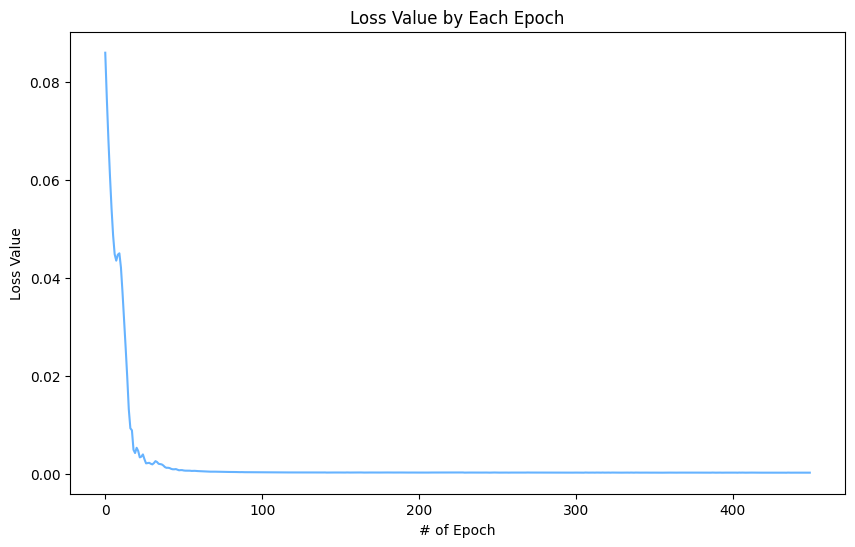

In [152]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 6)
p = sns.lineplot(history, color = (0.40, 0.70, 1.00))
_ = p.set(title = 'Loss Value by Each Epoch', xlabel = '# of Epoch', ylabel = 'Loss Value')
# dplt.plot(history.history['val_loss'])

In [153]:
X_test[0] # len() = period

array([[0.56737051, 0.57258501, 0.58487016, 0.59512243, 0.60042533,
        0.59211748, 0.59821579, 0.60387222, 0.60042533, 0.59777391,
        0.59742038, 0.58186514, 0.57408756, 0.58363275]])

In [154]:
# X_train_X_test = np.concatenate((X_train, X_test),axis=0)
# hidden_state = None
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [155]:
test_predict_cpu.shape

(1272, 1, 1)

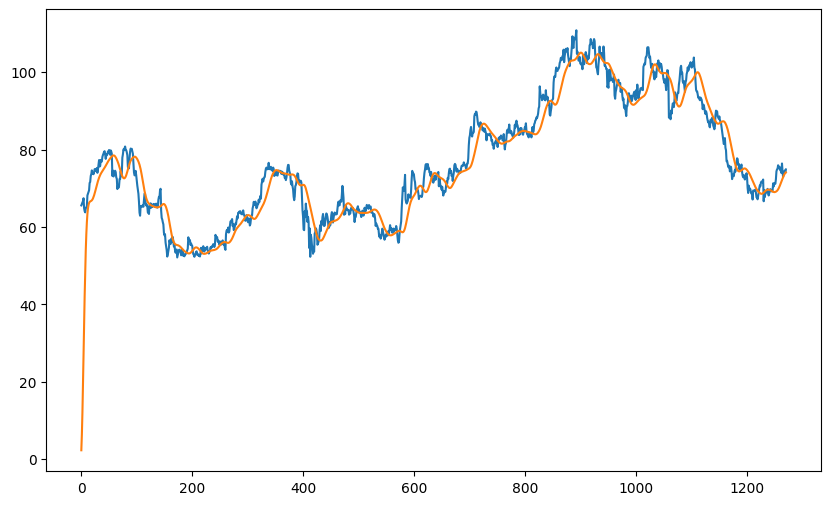

In [156]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))
# its prediction on training dataset always "lagging"

In [157]:
# calculate RMSE of the test data

actual = sc.inverse_transform(y_test.reshape(-1,1))
# lens = len(sc.inverse_transform(y_test.reshape(-1,1)))
predict = sc.inverse_transform(test_predict_cpu.reshape(-1,1))
RMSE = (((actual - predict) ** 2).mean()) ** 0.5

print(f'The RMSE of the predicted value is {round(RMSE, 2)}')

The RMSE of the predicted value is 5.27


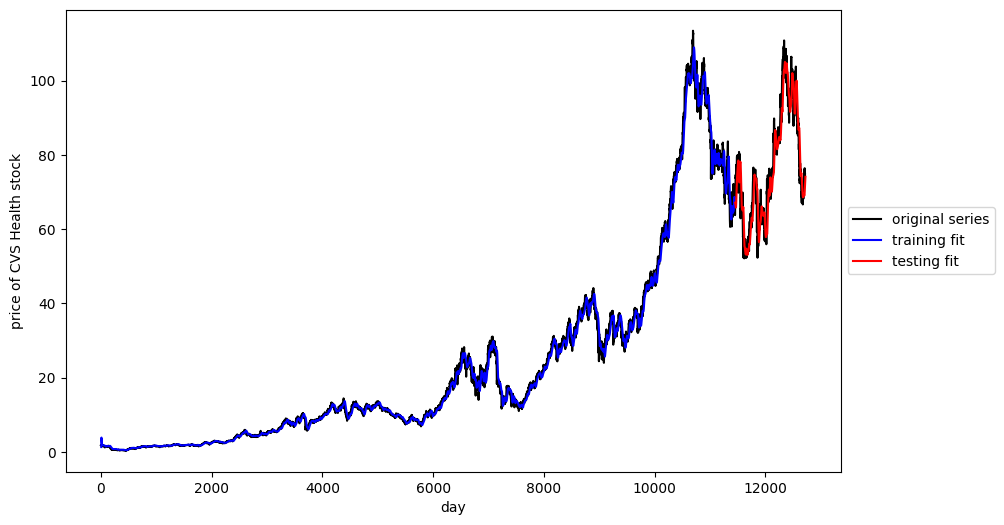

In [158]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.90) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of CVS Health stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## Result Summary & Conclusion

Through the usage of RNN+LSTM network within pytorch framework. I fine-tuned the model and its RMSE in test dataset was 5.27. Despite its lagging prediction, it could accurrately fit the overall long-term trend within a couple of day.

Therefore, it would not be a reliable approach to predict the short-time fluctration of the stock market. Instead, the LSTM model would be more competent to solve the long-run problem of the time-series data.